#### Prerequisites

- Basic familiarity with [Numpy](https://numpy.org/doc/stable/user/quickstart.html)
- Basic familiarity with [Pyplot](https://matplotlib.org/stable/tutorials/introductory/pyplot.html)

<a name="outline"></a>

## Outline

- [Section 1](#section-1): Intro to Logistic Regression
- [Section 2](#section-2): Dataset Generation
- [Section 3](#section-3): Logistic Parametric Function
- [Section 4](#section-4): Optimising Logistic Regression Parameters
- [Section 5](#section-5): Model evaluation
- [Extra 1](#extra-1): Receiver Operating Characteristic (ROC)

# Logistic regression
The purpose of this notebook is to understand and implement logistic regression. As always, you are not allowed to use any package that has a complete logistic regression framework implemented (*e.g.*, scikit-learn).



<a name="section-1"></a>

## Section 1: Intro to Logistic Regression [^](#outline)


Logistic regression, despite its name, is a linear model for classification rather than regression. In its original form, it is used for binary classifications, i.e., assigning a data point in our test set a binary label (*e.g.*, yes or no, 0 or 1, red or blue). The reason why the term logistic *regression* is used becomes obvious once we examine the logistic function (often also called sigmoid function):
$$
h(z) = \frac{1}{1+e^{-z}}
$$
Next, you will implement the logistic function using numpy.

In [11]:
# Importing standard packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Changing default font sizes
plt.rc('xtick', labelsize=16) # Tick labels
plt.rc('ytick', labelsize=16) # Tick labels
plt.rc('legend', fontsize=14) # Legend
plt.rc('axes', titlesize=24, labelsize=20) # Title and 'x' and 'y' labels

In [12]:
## EDIT THIS FUNCTION
def logistic(z):
    return 1. / (1. + np.exp(-z))  ## <-- SOLUTION

Let's plot the function to see how it behaves.

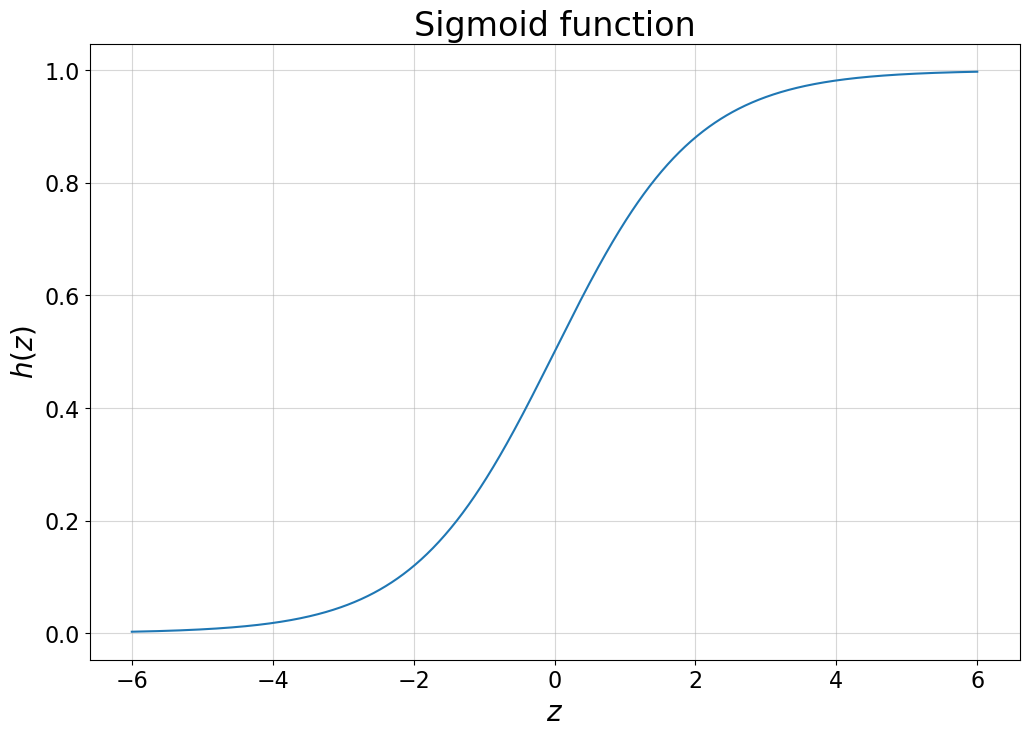

In [13]:
plt.figure(figsize=(12,8))
z = np.linspace(-6, 6, 1000)
y = logistic(z)
plt.xlabel(r'$z$')
plt.ylabel(r'$h(z)$')
plt.title('Sigmoid function')
plt.grid(alpha=0.5)
plt.plot(z, y);

#### Questions:
1. Can you already guess why this _regression_ model is used in _binary classification_ tasks?
2. What do the bounds of the logistic function tell you?


<a name="section-2"></a>

## Section 2: Dataset Generation [^](#outline)

Let's generate now a dataset with $p=2$ features using sklearn's [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function:

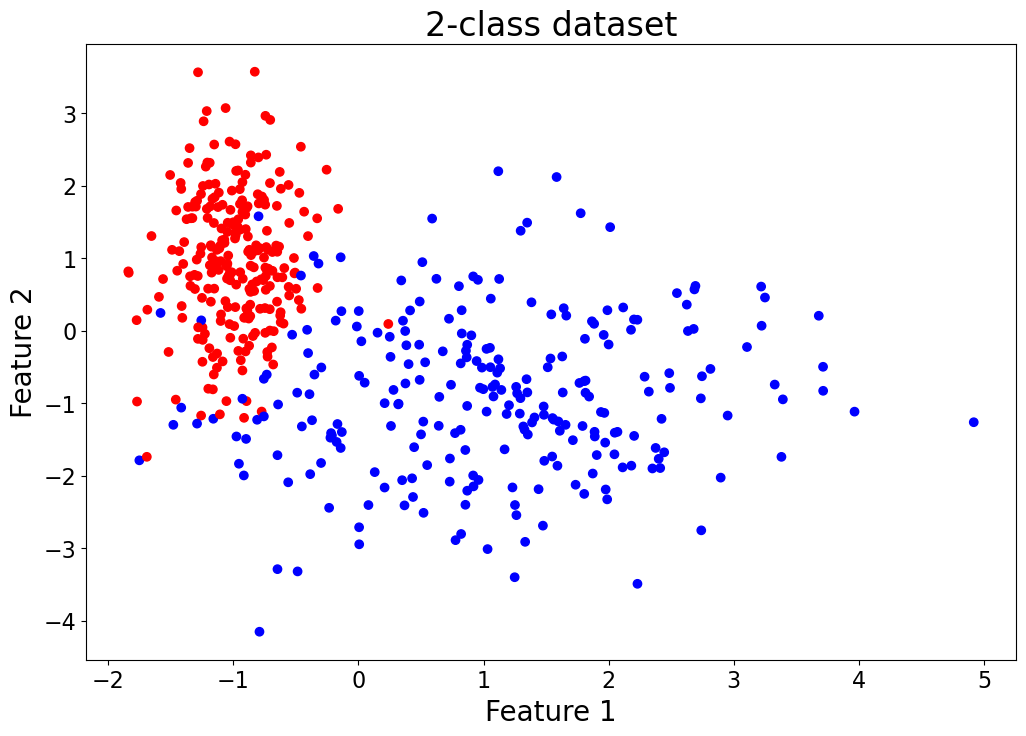

In [14]:
X_f, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=14)
plt.figure(figsize=(12,8))
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2-class dataset')
plt.scatter(X_f[:,0], X_f[:,1], c=y.reshape(-1), cmap='bwr');

We divide the dataset into training and test set and run our model with our own choice of hyperparameters:

In [15]:
# Adding a first column of ones allowing for a bias/intercept term
X = np.hstack((np.ones((X_f.shape[0], 1)), X_f))

# Stacking data 'X' and labels 'y' into one matrix
data = np.hstack((X, y[:, np.newaxis]))

# Shuffling the rows        
np.random.shuffle(data)

# Splitting into training and test in a 70-30 ratio
split_rate = 0.7
train, test = np.split(data, [int(split_rate*(data.shape[0]))])

X_train = train[:,:-1]
y_train = train[:, -1]

X_test = test[:,:-1]
y_test = test[:, -1]

y_train = y_train.astype(int)
y_test = y_test.astype(int)

<a name="section-3"></a>

## Section 3: Logistic Parametric Function [^](#outline)

In logistic regression, we estimate the parameter vector $\boldsymbol \beta=[\beta_0, \beta_1, \dots, \beta_p]^T \in \mathbb R^{p+1}$ as in linear regression. However, the final step involves passing the output through a logistic function. We call the output of this operation $h_{\boldsymbol \beta}(\boldsymbol X)$:

$$
h_{\boldsymbol \beta}(\boldsymbol X) := h(\boldsymbol X \boldsymbol \beta)
$$

where $\boldsymbol X = 
\begin{bmatrix}
    \vert & &\vert \\
    \boldsymbol x^{(1)} & \dots  & \boldsymbol x^{(N)}   \\
    \vert & &\vert
\end{bmatrix}^{\ T}
$ and $\boldsymbol x^{(i)} = [1, x_1^{(i)}, \dots, x_p^{(i)}]^T \in \mathbb R^{p+1}$.

Note that $h$ is again the logistic function and, consequently, we have a _probability_ of the given data point belonging to one of the two classes, such as red or blue. To label the data points, we can designate those with a probability above $0.5$ as red and those with a probability of $0.5$ or below as blue.

In the following cell, write an implementation of $h_{\boldsymbol \beta}(\boldsymbol X)$.

In [16]:
## EDIT THIS FUNCTION
def predict_log(X, beta):
    y_log = logistic(X @ beta)  ## <-- SOLUTION
    return y_log.squeeze()

<a name="section-4"></a>

## Section 4: Optimising Logistic Regression Parameters [^](#outline)

### Parameter Initialisation

A common technique in Machine Learning is to initialise the parameter vector $\boldsymbol \beta$ randomly or with zeros; we do the latter here.

In [17]:
def initialise(size):
    """    
    Argument:
    size: Size of the parameter vector beta
  
    Returns:
    beta: Initialised vector of shape (size, 1)
    
    """
    
    beta = np.zeros((size, 1))
    
    return beta

### Parameter Optimisation

From the lecture notes, we know that the logistic regression parameters can be estimated by maximising the log-likelihood function. We can then consider the **negative log-likelihood** loss function and **minimise** the associated **mean sample loss**:

$$
E(L) = - \frac{1}{N}\sum_{i=1}^N y^{(i)} \log h_{\boldsymbol \beta}(\boldsymbol x^{(i)}) + (1-y^{(i)}) \log (1-h_{\boldsymbol \beta}(\boldsymbol x^{(i)})) 
$$
Which has as gradient
$$
\nabla_{\boldsymbol \beta} E(L) = \frac{1}{N}\sum_{i=1}^N (h_{\boldsymbol \beta}(\boldsymbol x^{(i)}) - y^{(i)})\boldsymbol x^{(i)} 
$$

Implement the mean sample loss function and its gradient in the next cell as part of a larger operation which we shall call `propagate`, often also called a _forward pass_.

In [18]:
## EDIT THIS FUNCTION
def propagate(X, y, beta):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    mean_loss: Mean sample loss for the negative log-likelihood
    dbeta: Gradient of the mean sample loss with respect to beta

    """
    y_log = predict_log(X, beta)

    # Mean sample loss function
    mean_loss = - np.mean(y * np.log(y_log) + (1-y) * np.log(1 - y_log))

    # Derivatives
    dbeta = np.mean(X.T * (y_log - y), axis=1).reshape(-1, 1) #* ...  ## <-- SOLUTION

    mean_loss = np.squeeze(mean_loss)
    
    # Store gradients in a dictionary
    grads = {'dbeta': dbeta}
      
    return grads, mean_loss

We can now conduct the actual optimisation and update the $\boldsymbol \beta$ with a learning rate $\alpha$, which we shall set to $0.1$. You are required to implement the updating procedure for $\boldsymbol \beta$:

$$
\boldsymbol \beta := \boldsymbol \beta - \alpha \nabla_{\boldsymbol \beta}  E(L)
$$


In [19]:
## EDIT THIS FUNCTION
def optimise(X, y, beta, num_iterations=1000, learning_rate=0.1, print_loss=False):
    """
    Arguments:
    X: Data of shape (N, p+1)
    y: True label vector of size N
    beta: Parameter vector, a numpy array of size p+1
    num_iterations: Number of iterations
    learning_rate: Step size in updating procedure
    print_loss: 'True' to print the mean loss every 100 iterations

    Returns:
    params: Dictionary containing the parameter vector beta
    grads: Dictionary containing the gradient
    mean_loss_history: List of all the mean loss values computed during the optimisation (can be used to plot the learning curve)

    """
    mean_loss_history = []
    
    for i in range(num_iterations):

        # Calculating the loss and gradients (hint: use your existing functions)
        grads, mean_loss = propagate(X, y, beta)  ## <-- SOLUTION
        
        # Retrieving derivatives from grads
        dbeta = grads['dbeta']
        
        # Updating procedure
        beta = beta - learning_rate * dbeta  ## <-- SOLUTION
        
        # Record the loss values
        if i % 100 == 0:
            mean_loss_history.append(mean_loss)
        
        # Printing the loss every 100 iterations
        if print_loss and i % 100 == 0:
            print ('Mean loss after iteration %i: %f' %(i, mean_loss))
    
    # Saving parameters and gradients in dictionary
    params = {'beta': beta}
    grads = {'dbeta': dbeta}
    
    return params, grads, mean_loss_history

<a name="section-5"></a>

## Section 5: Model Evaluation [^](#outline)

Having calculated the parameters for our training set, we can predict the labels for the test set.

In [20]:
## EDIT THIS FUNCTION
def predict(X_test, beta):
    """
    Arguments:
    X_test: Test set of shape (N_test, p+1)
    beta: Parameter vector, a numpy array of size p+1

    Returns:
    y_pred: Vector containing all binary predictions (0/1) for X_test
    
    """
    N_test = X_test.shape[0]
    y_pred = np.zeros((N_test, 1))
    beta = beta.reshape(X_test.shape[1], 1)
    
    # Predicting the probabilities
    y_log = predict_log(X_test, beta)
    
    y_pred = y_log.round().reshape(1, -1) # <-- SOLUTION
    
    return y_pred

A pythonic way to define an algorithm is placing all functions in one model that has all hyperparameters as arguments. This allows you to quickly evaluate different hyperparameters and optimise over these. So, let's do this:

In [21]:
def model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.1, print_loss=False):
    # Initialising parameters with zeros
    beta = initialise(X_train.shape[1])

    # Gradient descent
    parameters, grads, mean_loss_history = optimise(X_train, y_train, beta, num_iterations, learning_rate, print_loss=print_loss)

    # Retrieving parameter vector beta from dictionary 'parameters'
    beta = parameters['beta']

    # Predicting test and training set examples
    y_pred_test = predict(X_test, beta)
    y_pred_train = predict(X_train, beta)

    # Printing train/test accuracy
    print('Training accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print('Test accuracy: {} %'.format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # Saving all the information
    d = {'mean_loss_history': mean_loss_history, 'y_pred_test': y_pred_test, 'y_pred_train': y_pred_train, 'beta': beta, 'learning_rate': learning_rate, 'num_iterations': num_iterations}
    
    return d

In [22]:
# Running the model
d = model(X_train, y_train, X_test, y_test, num_iterations=500, learning_rate=0.1, print_loss=True)

Mean loss after iteration 0: 0.693147
Mean loss after iteration 100: 0.195345
Mean loss after iteration 200: 0.167134
Mean loss after iteration 300: 0.155319
Mean loss after iteration 400: 0.148548
Training accuracy: 95.14285714285714 %
Test accuracy: 95.33333333333333 %


Let's see how our loss has changed over the training iterations:

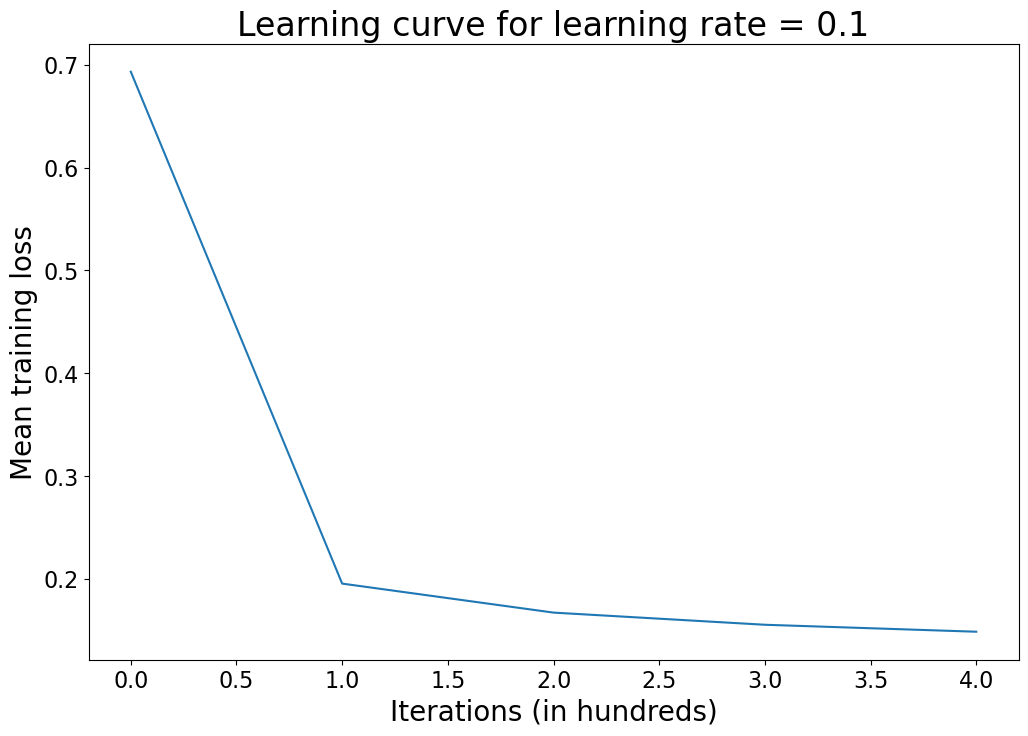

In [23]:
loss_history = np.squeeze(d['mean_loss_history'])
plt.figure(figsize=(12,8))
plt.ylabel('Mean training loss')
plt.xlabel('Iterations (in hundreds)')
plt.title('Learning curve for learning rate = ' + str(d['learning_rate']))
plt.plot(loss_history);

#### Questions:
1. What insights do you gain from this learning curve?
2. Try different learning rates, run the model again, and plot the learning curve. What can you observe?
3. Use different random states when you generate the data and run the model again. What can you observe?
4. Increase the number of features in your generated data and evaluate the accuracies again. How do they change?
5. Generate data with sklearn's [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function (noise $> 0.1$) and evaluate how well logistic regression performs on this dataset.
6. By performing logistic regression, we have estimated the parameter vector $\boldsymbol \beta$ that defines a decision boundary. This is illustrated in the cell below. What does this boundary (the dashed line) mean?

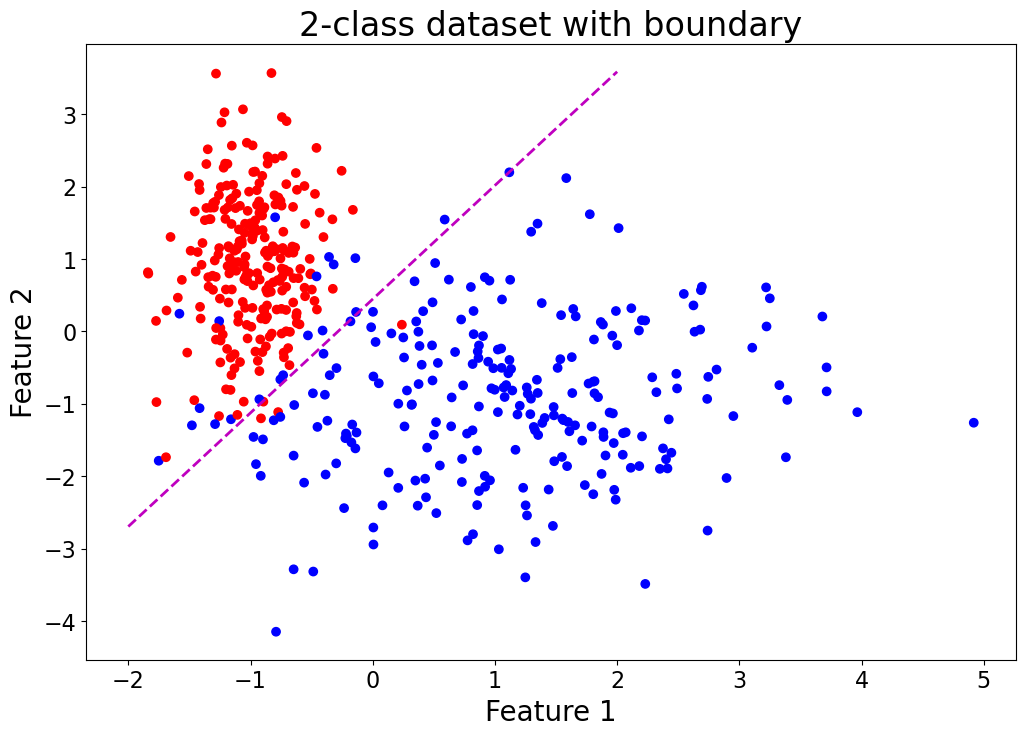

In [24]:
beta = np.squeeze(d['beta']) 

plt.figure(figsize=(12,8))
x1 = np.asarray([-2,2])
m = -beta[1]/beta[2]
c = -beta[0]/beta[2]
x2 = m*x1 + c
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.scatter(X[:,1], X[:,2], c=y.reshape(-1), cmap='bwr');
plt.plot(x1, x2, 'm--', lw=2)
plt.title('2-class dataset with boundary')
plt.show()

<a name="extra-1"></a>

## Extra 1: Receiver Operating Characteristic (ROC) [^](#outline)


Now we can raise interesting questions about accuracy as a metric that we have already used. Recall our functions `predict` and `predict_log`, where `predict` rounds the probabilities computed by `predict_log`. Rounding means that if the probability is greater than or equal 0.5, then we assign a label of 1 to this example. Consider now two testing examples introduced to the model $\boldsymbol x^{(i)}$ and $\boldsymbol x^{(j)}$ both sampled with label 1, and the model produces as probabilities $h_{\boldsymbol \beta}(\boldsymbol x^{(i)}) = 0.49$ and  $h_{\boldsymbol \beta}(\boldsymbol x^{(j)}) = 0.001$. After rounding, using accuracy as a metric will treat both examples equally as false negatives. However, this would neglect the closeness of $h_{\boldsymbol \beta}(\boldsymbol x^{(i)}) = 0.49$ to the decision boundary, as opposed to $h_{\boldsymbol \beta}(\boldsymbol x^{(j)}) = 0.001$.


Receiver Operating Characteristic (ROC) curve aims to capture the model output probabilities (or scores) into the quantification of the model performance. In lecture notes, you have learned that ROC curve can be constructed by computing True Positive Rate (TPR) and False Positive Rate (FPR) for a range of thresholds. An ideal model would have Area Under the Curve (AUC) of 1, while a model with random decisions would have an AUC of 0.5.

Let's consider the following procedure to construct a ROC curve:


1. Define the set of thresholds. This can be uniformly spaced thresholds between 1 and 0. However, the number of threshold values to consider remains a parameter. Alternatively, we may consider only the distinct probability values in `y_log`. 
> For example, if the computed `y_log` for four-examples is `[0.8, 0.4, 0.9, 0.8]`, then we have `{0.4, 0.8, 0.9}` as distinct values. If we scan the range of thresholds from 1 to 0 using very small steps, we can see that the FPR and TPR will remain unchanged unless we cross these values `{0.9, 0.8, 0.4}`. This means we can just use the distinct values in `y_log` (sorted in decreasing order) as threshold values to evaluate the list of TPR and FPR that we need to construct the ROC curve.
2. Starting from the greatest to the least threshold, compute the TPR and FPR and store them in an array or list.
3. At this point, AUC can be computed using the Trapezoidal rule (see [numpy.trapz](https://numpy.org/doc/stable/reference/generated/numpy.trapz.html)).




In [25]:
def roc_curve(y_true, y_log):
    """
    Arguments:
    y_true: Ground truth labels with size N
    y_log: Probabilities produced by logistic regression model with size N
  
    Returns:
    auc: Area Under the Curve (AUC)
    tpr_l: List of true positive rate (TPR) values for each scanned threshold
    fpr_l: List of false positive rate (FPR) values for each scanned threshold
    thresholds: Scanned thresholds sorted in decreasing order
    
    """
    # List of distinct values in y_log, sorted sorted in decreasing order
    thresholds = reversed(sorted(set(y_log))) # <-- SOLUTION
    tpr_l, fpr_l = [], []

    for threshold in thresholds:
        # Thresholding
        y_thresholded = (y_log >= threshold)

        # True positives
        tp = np.sum(y_true & y_thresholded)
        # True negatives
        tn = np.sum((~y_true) & (~y_thresholded))
        # False positives
        fp = np.sum((~y_true) & y_thresholded)
        # False negatives
        fn = np.sum(y_true & (~y_thresholded))

        tpr = tp / (tp + fn) # <-- SOLUTION
        fpr = fp / (tn + fp) # <-- SOLUTION
        tpr_l.append(tpr)
        fpr_l.append(fpr)

    # Compute AUC using Trapezoidal rule
    auc = np.trapz(tpr_l, fpr_l)
    return auc, tpr_l, fpr_l, thresholds

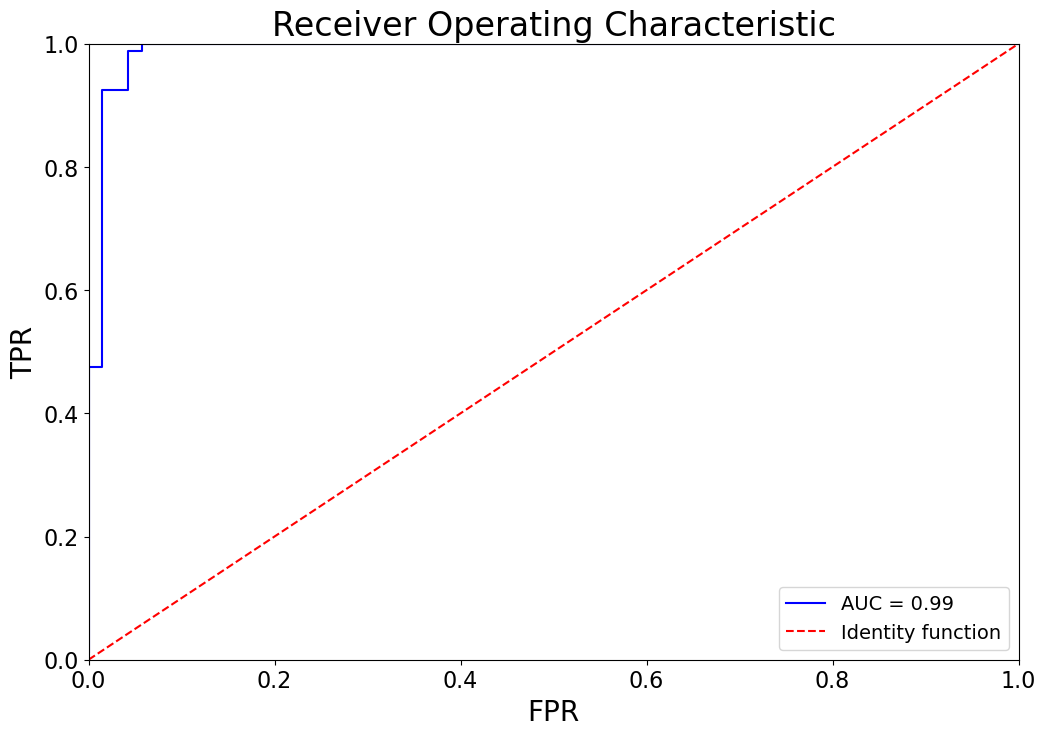

In [26]:
y_log = predict_log(X_test, d['beta'])
auc, tpr, fpr, th = roc_curve(y_test, y_log)

plt.figure(figsize=(12,8))
plt.title(f'Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label=f'AUC = {auc:0.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Identity function')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()


#### Questions:
1. Compare the AUC you get with `sklearn.metrics.roc_curve` and `sklearn.metrics.auc`.
1. Plot the ROC curve for training and test on the same plot. What can you observe?
3. Can you replicate your results using [sklearn](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)?
6. Based on sklearn's documentation, can you see any differences in the algorithms that are implemented in sklearn?